In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import imutils, ipynb

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array

In [4]:
img = cv2.imread("sud.png")

In [5]:
type(img)

numpy.ndarray

In [6]:
def show_pic(img):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

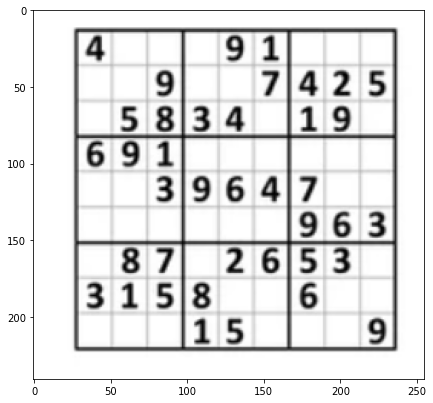

In [7]:
show_pic(img)

In [8]:
def get_persp(img, location, height = 900, width = 900):
    
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    
    matrix = cv2.getPerspectiveTransform(pts1, pts2) # returns matrix of transformation
    result = cv2.warpPerspective(img, matrix, (width, height)) # gets the transformed image
    
    return result

In [9]:
def find_board(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    
    edged = cv2.Canny(bfilter, 30 , 180)
    
    # key_pts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contours, heir= cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # contours = imutils.grab_contours(key_pts) 
    # grabs the contours from key_pts tuple

    new_img = cv2.drawContours(img.copy(), contours, -1, [255, 0, 0], thickness = 5)
    
    # -1 for drawing all cont
    
    # show_pic(new_img)
    
    contours = sorted(contours, key = cv2.contourArea, reverse =1)[:10]
    
    location = None
    
    for c in contours:
    
        approx = cv2.approxPolyDP(c, 15, True) # approximates the contour to a rectangle
   
        if len(approx) == 4:
            location = approx
            break
        
    result = get_persp(img, location)
    gray_res  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return result, location

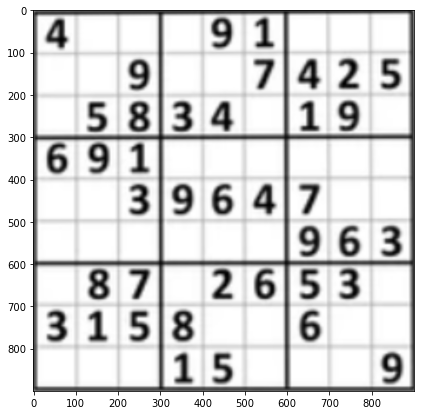

In [10]:
board, location = find_board(img)

show_pic(board)

In [11]:
board.shape

(900, 900, 3)

In [12]:
# cont, heir= cv2.findContours(edged.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [13]:
# ccomp_img = cv2.drawContours(img.copy(), cont, -1, (255,0,0), -1)
# show_pic(ccomp_img)

In [14]:
def split_boxes(board):
    
    rows = np.vsplit(board, 9)
    
    boxes = []
    
    for r in rows:
        cols = np.hsplit(r, 9)
        
        for box in cols:
            box = cv2.resize(box, (5,5))/255.0
            
            boxes.append(box)
            
    return boxes

In [15]:
# gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)

In [16]:
# rois = split_boxes(gray)

In [17]:
# rois = np.array(rois).reshape(-1, 5, 5, 1)

In [18]:
# show_pic(boxes[1])

In [27]:
from skimage.segmentation import clear_border

In [15]:
warped = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)

In [16]:
step_x = board.shape[0] // 9
step_y = board.shape[1] // 9

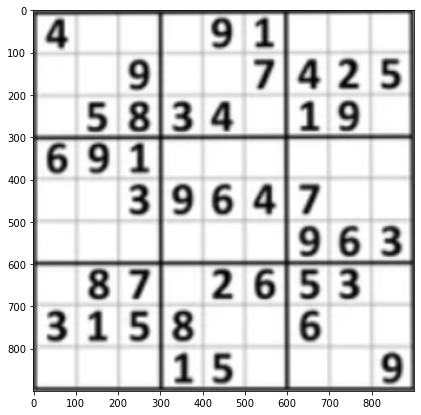

In [17]:
show_pic(warped)

In [24]:
import joblib

In [18]:
import keras

In [19]:
model = keras.models.load_model('99percent.h5')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                    

In [28]:
def extract_digit(cell):
    thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    thresh = clear_border(thresh)
        
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours = imutils.grab_contours(contours)
    
    if len(contours) == 0:
        return None
    
    c = max(contours, key = cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype = 'uint8')
    cv2.drawContours(mask, [c], -1, 255, -1)
    
    (h, w) = thresh.shape
    percent_filled = cv2.countNonZero(mask)/float(w*h)
    
    if percent_filled < 0.03:
        return None
    
    digit = cv2.bitwise_and(thresh, thresh, mask)
    
    return digit

In [45]:
op_board = np.zeros((9, 9), dtype="int")

In [46]:
cell_locs = []

for y in range(0, 9):
    
    row =  []
    
    for x in range(9):
        
        start_x = x*step_x
        start_y = y*step_y
        
        end_x = start_x + step_x
        end_y = start_y + step_y
        
        row.append((start_x, start_y, end_x, end_y))
        
        cell = warped[start_y:end_y , start_x: end_x]
        
        digit = extract_digit(cell) 
        
        if digit is not None:
            
            roi = cv2.resize(digit, (28, 28))
            roi = roi.astype("float") / 255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi, axis=0)
            
            pred = model.predict(roi).argmax(axis =1)[0]
            print("x, y", x, y, pred)
            op_board[y, x] = pred
            
    cell_locs.append(row)

1/1 [==============================] - 0s 54ms/step
x, y 0 0 8
1/1 [==============================] - 0s 37ms/step
x, y 4 0 9
1/1 [==============================] - 0s 57ms/step
x, y 5 0 1
1/1 [==============================] - 0s 55ms/step
x, y 2 1 9
1/1 [==============================] - 0s 55ms/step
x, y 5 1 7
1/1 [==============================] - 0s 59ms/step
x, y 6 1 4
1/1 [==============================] - 0s 48ms/step
x, y 7 1 2
1/1 [==============================] - 0s 77ms/step
x, y 8 1 5
1/1 [==============================] - 0s 51ms/step
x, y 1 2 5
1/1 [==============================] - 0s 53ms/step
x, y 2 2 8
1/1 [==============================] - 0s 64ms/step
x, y 3 2 3
1/1 [==============================] - 0s 61ms/step
x, y 4 2 9
1/1 [==============================] - 0s 48ms/step
x, y 6 2 1
1/1 [==============================] - 0s 75ms/step
x, y 7 2 9
1/1 [==============================] - 0s 55ms/step
x, y 0 3 6
1/1 [==============================] - 0s 63ms/step
x, 

In [47]:
def show_board(board):
    for row in board:
        for c in row:
            print(c, end = "  ")    
        print("\n")

In [48]:
op_board[0, 0] = 4
op_board[2,4] = 4
op_board[4, 6] = 7
op_board[6, 2] = 7

In [49]:
show_board(op_board)

4  0  0  0  9  1  0  0  0  

0  0  9  0  0  7  4  2  5  

0  5  8  3  4  0  1  9  0  

6  9  1  0  0  0  0  0  0  

0  0  3  9  6  4  7  0  0  

0  0  0  0  0  0  9  6  3  

0  8  7  0  2  6  5  3  0  

3  1  5  8  0  0  6  0  0  

0  0  0  1  5  0  0  0  9  



In [50]:
def print_grid(arr):
    for r in arr:
        for c in r:
            print(c, end = "  ")
        print('\n')

In [51]:
def is_safe(arr, r, c, num):
    
    for i in range(9):
        if arr[i][c] == num:
            return False
        
    for j in range(9):
        if arr[r][j] == num:
            return False
        
    start_row = r - r%3
    start_col = c - c%3
    
    for i in range(3):
        for j in range(3):
            if arr[start_row + i][start_col + j] == num:
                return False
    
    
    return True

In [52]:
def solve_sudoku(arr, r, c):
    

    
    if c == 9:
        r += 1
        c = 0
        
    if r == 9 and c == 0:
        return True  
    
    if arr[r][c] > 0:
        return solve_sudoku(arr, r, c+1)
        
    for num in range(1, 10, 1):
        
        if is_safe(arr, r, c, num):
            
            arr[r][c] = num
            
            #if solve(arr, r, c+1)
            if solve_sudoku(arr, r, c+1):
                return True
        
        arr[r][c] = 0 # backtracking step to make whatever changes made by solve sudoku back to 0
        
    return False

In [53]:
if solve_sudoku(op_board, 0, 0):
    print_grid(op_board)
else: print("NO")

4  6  2  5  9  1  3  8  7  

1  3  9  6  8  7  4  2  5  

7  5  8  3  4  2  1  9  6  

6  9  1  7  3  8  2  5  4  

5  2  3  9  6  4  7  1  8  

8  7  4  2  1  5  9  6  3  

9  8  7  4  2  6  5  3  1  

3  1  5  8  7  9  6  4  2  

2  4  6  1  5  3  8  7  9  

